In [403]:
import numpy as np
from numpy.polynomial.laguerre import laggauss
from scipy.special import exp1
from matplotlib import pyplot as plt
from math import isclose
from IPython import display
from scipy.integrate import quad
from scipy.interpolate import interp1d
from numpy.polynomial.legendre import leggauss

import warnings
warnings.filterwarnings("ignore", message="The occurrence of roundoff error is detected")
warnings.filterwarnings("ignore", message="The maximum number of subdivisions")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

# Part 1: Lambda iteration

In [2]:
#Chandrasekhar solution

k,k1,k2,k3=0,1.103188,1.591778,4.45808
Q,L1,L2,L3=0.706920,-0.083921,-0.036187,-0.009461

q_chandra = lambda tau: Q + L1*np.exp(-k1*tau) + L2*np.exp(-k2*tau) + L3*np.exp(-k3*tau)

In [44]:
#Lambda iteration

def lambda_operator(q,tau,t_max):
    
    integrand = lambda t,tau: (t + q(t)) * exp1(np.abs(t-tau))
    return 0.5*quad(integrand,0,t_max,args=tau)[0]

def iterate_q(q,n_iter,t_max=40):
    
    tau = np.linspace(0,t_max,500) #only integrate up to t_max
    plot_idx=np.abs(tau-5).argmin()
    plt.plot(tau[:plot_idx],q_chandra(tau[:plot_idx])) #Chandrasekhar solution for comparison
    
    for i in range(n_iter):
        
        # new q(tau) values after a lambda iteration
        y = np.array([lambda_operator(q,t,t_max)-t for t in tau])
        y[y==np.inf]=0 #avoid infinity at boundary
        idx=np.argmax(y) #find max of q(tau)
        y[idx:]=y[idx] #cheat by assuming monotonic
        
        for j in range(len(tau)-1): #also impose monotonicity below max
            if y[j+1] < y[j]:
                y[j+1]=y[j]
        
        # interpolate q(tau) so that we can use quad
        #q = interp1d(tau,savgol_filter(y,n_filter,2)) # smooth data before interpolating
        q = interp1d(tau,y)
        
        #plot each iteration against Chandrasekhar solution
        plt.plot(tau[:plot_idx],q_chandra(tau[:plot_idx]),label='Chandrasekhar')
        plt.plot(tau[:plot_idx],q(tau[:plot_idx]),label=str(i))
        plt.legend(fontsize=15)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        display.display(plt.clf())
        
    return q

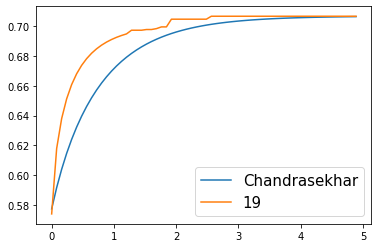

None

<Figure size 432x288 with 0 Axes>

In [45]:
q = lambda tau: 2/3 #Eddington approximation
q_new = iterate_q(q,20) #iterate lambda operator

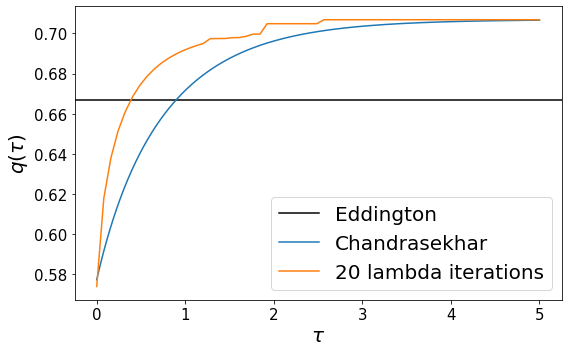

In [47]:
tau = np.linspace(0,5,1000)
plt.figure(figsize=(8,5))
plt.axhline(2/3,label='Eddington',color='k')
plt.plot(tau,q_chandra(tau),label='Chandrasekhar')
plt.plot(tau,q_new(tau),label='20 lambda iterations')
plt.legend(fontsize=20)
plt.xlabel(r'$\tau$',fontsize=20)
plt.ylabel(r'$q(\tau)$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('lambda_iteration.png')
plt.show()

In [48]:
#Solve for frequency spectrum

from scipy.special import expn

def q_func(q,tau): #extend domain of lambda iterated q(tau) to infinity
    if tau <= q.x[-1]:
        return q(tau)
    if tau > q.x[-1]:
        return q(q.x[-1])
    
nu = np.linspace(1e-3,1000,10000)

#Chandrasekhar
T_chandra = lambda tau: (tau + q_chandra(tau))**0.25
B_nu_chandra = lambda tau,nu: (2*nu**3) / (np.exp(nu/T_chandra(tau)) - 1)

integrand_chandra = lambda tau,nu: B_nu_chandra(tau,nu) * expn(2,tau)
F_nu_chandra = 2*np.pi*np.array([quad(integrand_chandra,0,np.inf,args=nu)[0] for nu in nu])

#Eddington
T_edd = lambda tau: (tau + 2/3)**0.25
B_nu_edd = lambda tau,nu: (2*nu**3) / (np.exp(nu/T_edd(tau)) - 1)

integrand_edd = lambda tau,nu: B_nu_edd(tau,nu) * expn(2,tau)
F_nu_edd = 2*np.pi*np.array([quad(integrand_edd,0,np.inf,args=nu)[0] for nu in nu])

#Numerical
T = lambda tau: (tau + q_func(q_new,tau))**0.25
B_nu = lambda tau,nu: (2*nu**3) / (np.exp(nu/T(tau)) - 1)

integrand = lambda tau,nu: B_nu(tau,nu) * expn(2,tau)
F_nu = lambda nu: 2*np.pi*quad(integrand,0,np.inf,args=nu)[0]
F_nu = 2*np.pi*np.array([quad(integrand,0,np.inf,args=nu)[0] for nu in nu])

In [260]:
#compute T_eff from integration of F_nu
from scipy import integrate
F = np.sum(F_nu)
T_eff = F**0.25/np.pi

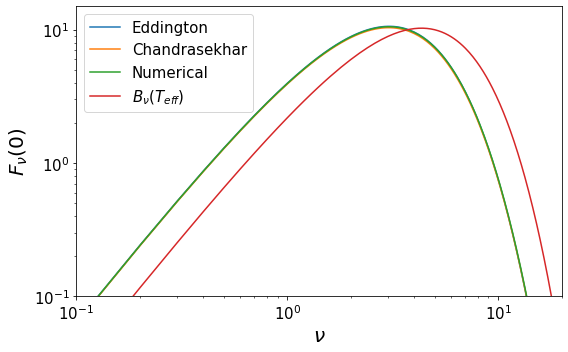

In [809]:
plt.figure(figsize=(8,5))

plt.loglog(nu,F_nu_edd,label='Eddington')
plt.loglog(nu,F_nu_chandra,label='Chandrasekhar')
plt.loglog(nu,F_nu,label='Numerical')

B_nu_T_eff = (2*nu**3) / (np.exp(nu/T_eff) - 1)
plt.loglog(nu,B_nu_T_eff,label=r'$B_\nu(T_{eff})$')

plt.xlabel(r'$\nu$',fontsize=20)
plt.ylabel(r'$F_\nu(0)$',fontsize=20)
plt.xlim(1e-1,20)
plt.ylim(1e-1,15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('flux.png')
plt.show()

In [53]:
#compute limb-darkening law

def limb_dark(q):
    return q(0)/(1+q(0))

ld_num = limb_dark(q_new)
print('Numerical limb-darkening =',np.round(ld_num,3))

ld_chandra = limb_dark(q_chandra)
print('Chandrasekhar limb-darkening =',np.round(ld_chandra,3))

Numerical limb-darkening = 0.365
Chandrasekhar limb-darkening = 0.366


# Part 2: Feautrier method

In [998]:
def j(mu,n,tau_max):
    delta_tau = tau_max/n
    
    # A matrix
    A = np.zeros((n, n))
    for i in range(1,n-1):
        A[i, i-1] = -mu**2/delta_tau**2
        A[i, i] = 1 + 2*mu**2/delta_tau**2
        A[i, i+1] = -mu**2/delta_tau**2
    # boundary conditions
    A[0, 0] = 1+2*mu/delta_tau+2*mu**2/delta_tau**2
    A[0,1] = -2*mu**2/delta_tau**2
    A[-1,-2] = -mu**2/delta_tau**2
    A[-1,-1] = 1+mu**2/delta_tau**2

    # S vector
    S = np.zeros(n)
    S = np.array([ delta_tau*i + q_func(q_new,delta_tau*i) for i in range(n)])
    
    return np.linalg.solve(A, S) #j vector

def h_mu(mu,n,tau_max):
    delta_tau = tau_max/n
    jj=j(mu,n,tau_max)
    h=np.zeros(n)
    h[1:-1] = mu*(jj[2:]-jj[:-2])/(2*delta_tau)
    return h

def F_tau(n,tau_max,deg):
    xi,wi = leggauss(deg)
    mat = np.zeros((deg,n))
    delta_tau=tau_max/n
    for i in range(deg):
        mat[i,:] = xi[i]*h_mu(xi[i],n,tau_max)
    return np.linspace(0,tau_max,n)[1:-1],(4*wi@mat)[1:-1]

In [999]:
#Compute F(tau)
n=200
tau_max=100
deg=200
delta_tau=tau_max/n
tau,ff=F_tau(n,tau_max,deg)

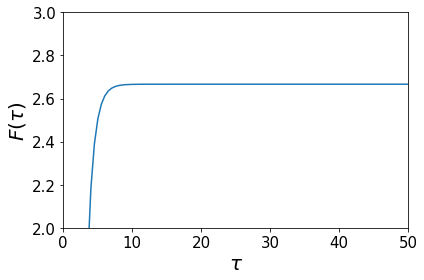

In [1000]:
plt.plot(tau,ff)
plt.xlabel(r'$\tau$',fontsize=20)
plt.ylabel(r'$F(\tau)$',fontsize=20)
plt.ylim(2,3)
plt.xlim(0,50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('constant_flux.png')
plt.show()